# The Caring Home / Helpful Home Continued

A model that can look for non normal situations in a elderly person home, from smart home IoT sensors.

## Enter RAG - Retrieval Augmented Generation!

And now - we put RAG and Frontier Models to the test.

In [5]:
# imports

import os
import sys
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic



In [6]:
# Lets include our sentence transformer
from sentence_transformers import SentenceTransformer, util

In [7]:
# Get the root project directory (one level up from the docs folder)
root_project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the src folder to the path
sys.path.insert(0, os.path.join(root_project_path, "src"))

In [8]:
from items import Item


In [9]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [10]:
# we need some new includes for our classes
from typing import List, Dict
from agents.agent import Agent
from agents.situations import Situation


In [11]:
# We will use Ollama locally for some models so we will need requests
import requests

In [12]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['OPENROUTER_API_KEY'] = os.getenv('OPENROUTER_API_KEY', 'your-key-if-not-using-env')
os.environ['HYPERBOLIC_API_KEY'] = os.getenv('HYPERBOLIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [13]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [14]:
openai = OpenAI()
claude = Anthropic()

In [15]:
%matplotlib inline

In [16]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('../data/train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('../data/test.pkl', 'rb') as file:
    test = pickle.load(file)

In [18]:
# We will use our training data file as the documents 

# Lets load the human trained documents file
#file_path = "data/memory.json"
# Lets load the related documents file
file_path = "../data/all_data.json"


def load_json_file(file_path):
    if not os.path.exists(file_path):
        return []
                
    with open(file_path, 'r') as f:
        return json.load(f)

load_json_file(file_path)

[{'situation': {'situation_description': 'The data reflects a consistent daily routine, including medication times, meal preparation, and relaxation periods. No unusual activity is detected.',
   'result': 'normal',
   'start_timestamp': 1737806400,
   'end_timestamp': 1737859800,
   'details': [{'timestamp': 1737806400,
     'room': 'pillbox',
     'nodeId': 1,
     'endpointId': 1,
     'attribute': {'OnOff': {'OnOff': True}}},
    {'timestamp': 1737806460,
     'room': 'bedroom',
     'nodeId': 2,
     'endpointId': 1,
     'attribute': {'OnOff': {'OnOff': True}}},
    {'timestamp': 1737806700,
     'room': 'bathroom',
     'nodeId': 2,
     'endpointId': 1,
     'attribute': {'OnOff': {'OnOff': True}}},
    {'timestamp': 1737807000,
     'room': 'bathroom',
     'nodeId': 3,
     'endpointId': 1,
     'attribute': {'RelativeHumidityMeasurement': {'MeasuredValue': 6500}}},
    {'timestamp': 1737807300,
     'room': 'bathroom',
     'nodeId': 2,
     'endpointId': 1,
     'attribute'

In [19]:
# We will use the Sentence Transformer to pick out closest documents

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def vector_search(file_path, query, top_k=5):
    # Load JSON data
    data = load_json_file(file_path)

    # Extract text data to embed and keep track of indices
    texts = [item['situation']['situation_description'] for item in data]

    # Return an empty list if there are no texts
    if not texts:
        return []
    
    # Ensure top_k does not exceed the number of available texts
    top_k = min(top_k, len(texts))
        
    # Create embeddings for each text
    embeddings = model.encode(texts, convert_to_tensor=True)

    # Create embedding for the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Compute cosine similarities
    similarities = util.pytorch_cos_sim(query_embedding, embeddings)[0]

    # Get the top_k results
    top_results = similarities.topk(top_k)

    # Return the most similar JSON objects
    return [data[idx] for idx in top_results.indices.tolist()]



README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

In [20]:
# Now check what is returned for bathroom

query = "Events the happen in the kitchen are important to me"
similar_situations = vector_search(file_path, query)
print(similar_situations)

[{'situation': {'situation_description': 'Light afternoon kitchen activity.', 'result': 'normal', 'start_timestamp': 1739192400, 'end_timestamp': 1739193000, 'details': [{'timestamp': 1739192400, 'room': 'kitchen', 'nodeId': 2, 'endpointId': 1, 'attribute': {'OnOff': {'OnOff': True}}}, {'timestamp': 1739192460, 'room': 'kitchen', 'nodeId': 2, 'endpointId': 1, 'attribute': {'Event': {'Event': 'fridge_opened'}}}, {'timestamp': 1739193000, 'room': 'kitchen', 'nodeId': 2, 'endpointId': 1, 'attribute': {'OnOff': {'OnOff': False}}}]}, 'estimate': 'normal'}, {'situation': {'situation_description': 'Light kitchen activity in the afternoon.', 'result': 'normal', 'start_timestamp': 1738881600, 'end_timestamp': 1738881720, 'details': [{'timestamp': 1738881600, 'room': 'kitchen', 'nodeId': 2, 'endpointId': 1, 'attribute': {'OnOff': {'OnOff': True}}}, {'timestamp': 1738881660, 'room': 'kitchen', 'nodeId': 2, 'endpointId': 1, 'attribute': {'Event': {'Event': 'fridge_opened'}}}, {'timestamp': 1738881

## First, the humble but mighty GPT-4o-mini

Lets try it with RAG

In [21]:
# We need to make the context using the vector search results

def make_context(similars: List[str]) -> str:
    """
    Create context that can be inserted into the prompt
    :param similars: similar situations to the one being estimated
    :param estimates: estimates of the similar situations
    :return: text to insert in the prompt that provides context
    """
    message = "To provide some context, here are some other situations that might be similar to the situations you need to estimate.\n\n"
    for similar in similars:
        details = json.dumps(similar['situation']['details'])
        estimate = similar['estimate']
        message += f"Potentially related situation:\n{details}\nEstimate is {estimate}\n\n"
    return message

def messages_for(situation: Situation, similar_situations: List[Situation]) -> List[Dict[str, str]]:
    """
    Create the message list to be included in a call to OpenAI
    With the system and user prompt
    :param description: a description of the situation to estimate
    :param similars: similar situations to this one
    :param estimates: estimates of similar situations
    :return: the list of messages in the format expected by OpenAI
    """
    system_message = "You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation"
    user_prompt = make_context(similar_situations)
    user_prompt += "And now the situaton for you:\n\n"
    details = situation.details
    user_prompt += "How would you classify this sensor data - normal or anomalous?\n\n" + json.dumps(details)
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Result is "}
    ]


In [22]:
# Try this out
messages_for(test[0], similar_situations)

[{'role': 'system',
  'content': 'You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation'},
 {'role': 'user',
  'content': 'To provide some context, here are some other situations that might be similar to the situations you need to estimate.\n\nPotentially related situation:\n[{"timestamp": 1739192400, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1739192460, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1739193000, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}]\nEstimate is normal\n\nPotentially related situation:\n[{"timestamp": 1738881600, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1738881660, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attri

In [23]:
# A utility function to extract the result from a string

def get_result(text):
    # Match "normal" or "anomalous" anywhere in the text
    match = re.search(r"\b(normal|anomalous)\b", text, re.IGNORECASE)
    return match.group(1).lower() if match else None

In [24]:
get_result("The result is anomalous because blah blah")

'anomalous'

In [25]:
get_result("anomalous")

'anomalous'

In [26]:
# Lets get similar situations for a real item
query = test[0].test_prompt()
#print(query)

similar_situations = vector_search(file_path, query)
print(similar_situations)

[{'situation': {'situation_description': 'The data shows a typical day with all expected activities occurring at regular times.', 'result': 'normal', 'start_timestamp': 1737979200, 'end_timestamp': 1738032600, 'details': [{'timestamp': 1737979200, 'room': 'pillbox', 'nodeId': 1, 'endpointId': 1, 'attribute': {'OnOff': {'OnOff': True}}}, {'timestamp': 1737979260, 'room': 'bedroom', 'nodeId': 2, 'endpointId': 1, 'attribute': {'OnOff': {'OnOff': True}}}, {'timestamp': 1737979500, 'room': 'bathroom', 'nodeId': 2, 'endpointId': 1, 'attribute': {'OnOff': {'OnOff': True}}}, {'timestamp': 1737979800, 'room': 'bathroom', 'nodeId': 3, 'endpointId': 1, 'attribute': {'RelativeHumidityMeasurement': {'MeasuredValue': 6500}}}, {'timestamp': 1737980100, 'room': 'bathroom', 'nodeId': 2, 'endpointId': 1, 'attribute': {'OnOff': {'OnOff': False}}}, {'timestamp': 1737980400, 'room': 'kitchen', 'nodeId': 2, 'endpointId': 1, 'attribute': {'OnOff': {'OnOff': True}}}, {'timestamp': 1737980460, 'room': 'kitchen

In [27]:
messages_for(test[0], similar_situations)

[{'role': 'system',
  'content': 'You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation'},
 {'role': 'user',
  'content': 'To provide some context, here are some other situations that might be similar to the situations you need to estimate.\n\nPotentially related situation:\n[{"timestamp": 1737979200, "room": "pillbox", "nodeId": 1, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1737979260, "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1737979500, "room": "bathroom", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1737979800, "room": "bathroom", "nodeId": 3, "endpointId": 1, "attribute": {"RelativeHumidityMeasurement": {"MeasuredValue": 6500}}}, {"timestamp": 1737980100, "room": "bathroom", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}

In [28]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, similar_situations),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

In [29]:
test[0].result

'anomalous'

1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1709341500, "room": "entr...
2: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738090800, "room": "livi...
3: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1741046400, "room": "livi...
4: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1741082100, "room": "hall...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709344800, "room": "bedr...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1709298000, "room": "kitc...
7: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709427600, "datetime": "...
8: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1804198800, "datetime": "...
9: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1737856800, "datetime": "...
10: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1737849600, "datetime": "...
11: Guess: anomalous Trut

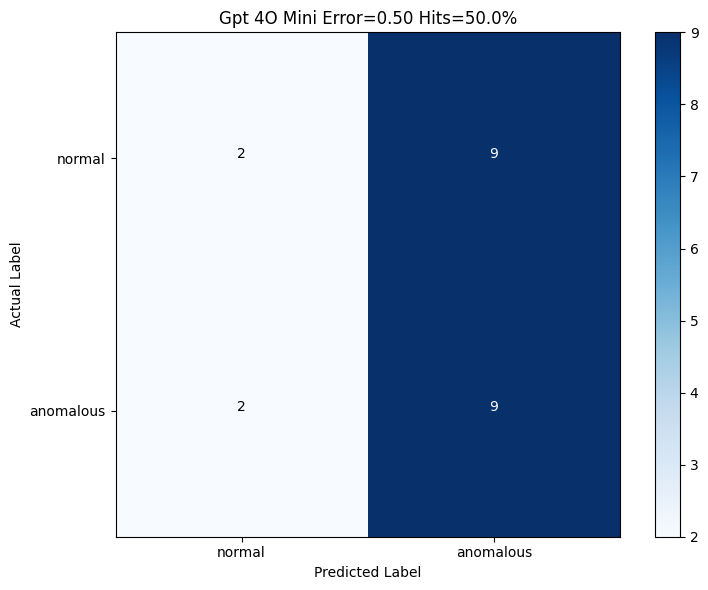

In [30]:
Tester.test(gpt_4o_mini, test)

In [31]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item, similar_situations),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

1: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709341500, "room": "entr...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738090800, "room": "livi...
3: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1741046400, "room": "livi...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741082100, "room": "hall...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709344800, "room": "bedr...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1709298000, "room": "kitc...
7: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709427600, "datetime": "...
8: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1804198800, "datetime": "...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1737856800, "datetime": "...
10: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1737849600, "datetime": "...
11: Guess: normal Truth: 

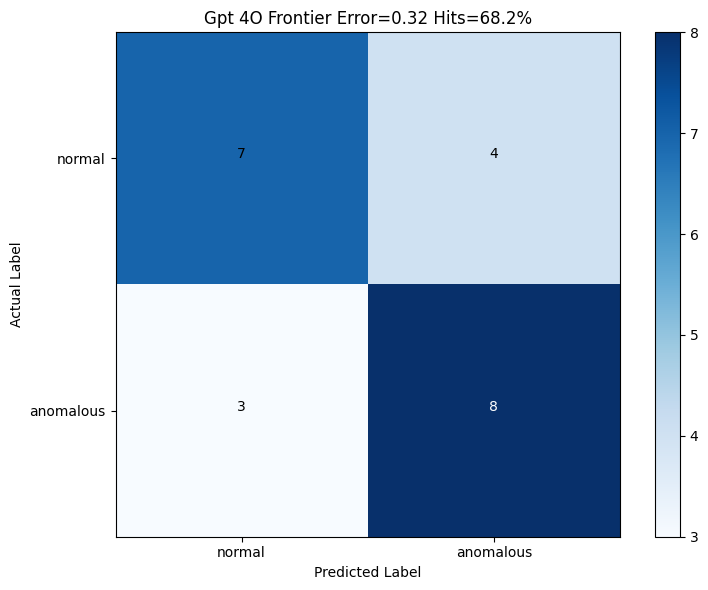

In [32]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

# We will try the Emerging models using Openrouter (API provider)



## Lets try Deepskeep with Openrouter!

And now - we put the Deepseek Models to the test.

In [37]:
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.environ['OPENROUTER_API_KEY'],
)


In [38]:
# Lets try hyperbolic using the Open AI library
hyperbolic_client = OpenAI(
  base_url="https://api.hyperbolic.xyz/v1",
  api_key=os.environ['HYPERBOLIC_API_KEY'],
)

In [39]:
import json

# Use Hyperbolic API to query the deepseek model
def deepseek_via_hyperbolic(item):
    response = hyperbolic_client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1",
        messages=messages_for(item, similar_situations),
        seed=42
    )
    print(json.dumps(response.__dict__, indent=4, default=str))
    reply = response.choices[0].message.content
    #print(reply)
    return get_result(reply)

In [40]:
test[0].prompt

'How would you classify this sensor data - normal or anomalous?\n\n[{"timestamp": 1738684800, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1738684860, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1738684920, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}, {"timestamp": 1738684980, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1738685040, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}]\n\n\nResult is anomalous'

In [41]:
print(deepseek_via_hyperbolic(test[0]))

{
    "id": "chatcmpl-z9WpU6bKMb3KoD9do94QjP",
    "choices": [
        "Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=' anomalous\\n\\nOkay, let\\'s break this down. The user provided some examples where certain sensor data sequences were classified as normal or anomalous. Now, they want me to determine if a new situation is normal or anomalous. \\n\\nLooking at the given examples: in the first two \"normal\" cases, there\\'s a sequence of turning on lights in different rooms, using the bathroom, kitchen activities, and so on. The fridge is opened once when the kitchen light is on, and then closed. Similarly, the pillbox and bedroom lights follow a routine. \\n\\nIn the \"anomalous\" examples, like the third one, there\\'s a missing node ID or a temperature spike. Another anomalous case has repeated fridge openings and closings in quick succession. The last example they provided for classification is similar to the anomalous one with multip

{
    "id": "chatcmpl-8owKrDAU2QTkpsqZokxcDe",
    "choices": [
        "Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content=' anomalous\\n\\nOkay, let\\'s analyze the given situation. The user provided some examples where certain patterns were considered normal or anomalous. Now, they want me to classify a new sensor data snippet as normal or anomalous.\\n\\nFirst, looking at the examples: \\n\\nIn the first two \"normal\" situations, the events follow a typical routine. For example, turning on the pillbox, moving to the bedroom, bathroom, kitchen, etc., with consistent timestamps and events like fridge opening followed by turning off the kitchen light after some time. The anomalous examples include unusual patterns, like a high temperature in the kitchen or repeated fridge openings and light toggles in quick succession without a clear purpose.\\n\\nThe situation to classify now is:\\n\\n- Kitchen light turned on (1738684800)\\n- Fridge opened (1

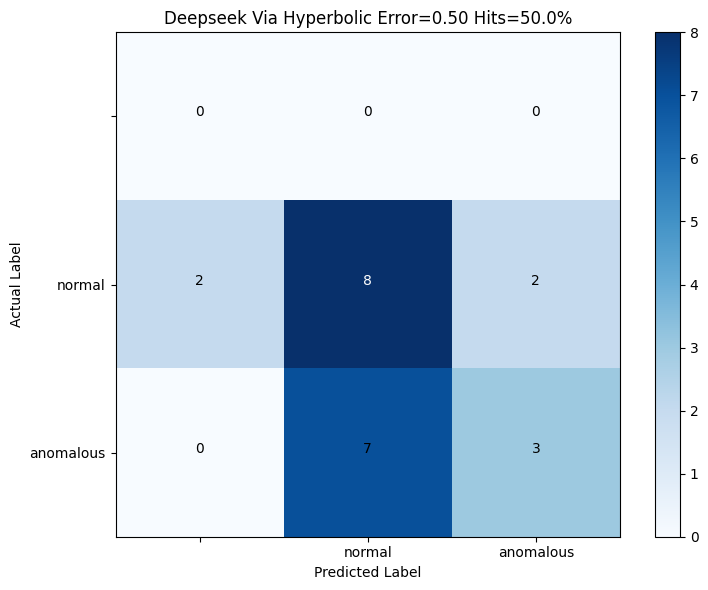

In [42]:
# The function for testing deepseek via hyperbolic

Tester.test(deepseek_via_hyperbolic, test)